# **Loan Default Prediction**: *Preprocessing & Baseline Modeling*
In this notebook we are carrying out the preprocessing steps, as well as setting up the baseline model.

As this is a classification project, we are preprocessing data tailoring it to the specific algorithm we are using at a specific time. Before splitting the data, we are ensuring it is in an optimal condition for modeling.

In [19]:
# Import relevant dependencies.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score

In [2]:
# Load dataset for preprocessing
loans_info = pd.read_csv("../Data/RawData/Loan_default.csv")  

# Preview data
loans_info.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In the next cell, we are dropping the ID column, because it is irrelevant.

In [3]:
# Drop irrelevant columns.
loans_info = loans_info.drop(columns= ['LoanID'])

To ensure that we do not have any categorical/standardization issues we are checking the values in each categorical column.

In [4]:
# View the most occuring records in categorical columns
for col in loans_info.select_dtypes(include='object').columns:
    print(f"\n--- {col.upper()} ---")
    print(loans_info[col].value_counts(dropna=False))


--- EDUCATION ---
Bachelor's     64366
High School    63903
Master's       63541
PhD            63537
Name: Education, dtype: int64

--- EMPLOYMENTTYPE ---
Part-time        64161
Unemployed       63824
Self-employed    63706
Full-time        63656
Name: EmploymentType, dtype: int64

--- MARITALSTATUS ---
Married     85302
Divorced    85033
Single      85012
Name: MaritalStatus, dtype: int64

--- HASMORTGAGE ---
Yes    127677
No     127670
Name: HasMortgage, dtype: int64

--- HASDEPENDENTS ---
Yes    127742
No     127605
Name: HasDependents, dtype: int64

--- LOANPURPOSE ---
Business     51298
Home         51286
Education    51005
Other        50914
Auto         50844
Name: LoanPurpose, dtype: int64

--- HASCOSIGNER ---
Yes    127701
No     127646
Name: HasCoSigner, dtype: int64


In [5]:
# Save cleaned data to a new file
loans_info.to_csv('../Data/CleanData/Cleaned_Loans_Data.csv', index= False)

## **Data Preprocessing**
In this section, we are preparing our data for modeling, this will involve, splitting the data to training and testing datasets.

- We are using sklearn's model selection function, `train-test-split` to split our data. This is an important for building reliable machine learning models as it allows us to train the model on one portion of the data and then assess its performance on a completely separate, unseen portion, which helps prevent overfitting and provides a realistic evaluation of how well the model generalizes to new data. 

In [6]:
# Assign predictors and target variable to their respective variables.
X = loans_info.drop('Default', axis=1)
y = loans_info['Default']

# Split the dataset to train and test datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


## **Baseline Model**
In this section we are training our baseline model, using the `Logistic Regression` algorithm.

Logistic regression requires the data to be standardized and the categorical columns be one hot encoded. Before we begin modeling, we are preprocessing the data, tailoring it to logistic regression's needs, that is:
- Standardizing the numerical columns.

- One hot encoding te categorical columns.

In [7]:
# Identify column types
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include='number').columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Fit transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Get new feature names 
# From numeric columns, they stay the same
num_features = numeric_cols

# From OneHotEncoder
cat_features = preprocessor.named_transformers_['cat'].get_feature_names(categorical_cols)

# Combine all new column names
all_features = list(num_features) + list(cat_features)

# Convert back to DataFrames
X_train_df = pd.DataFrame(X_train_processed.toarray() if hasattr(X_train_processed, 'toarray') else X_train_processed,
                          columns=all_features,
                          index=X_train.index)

In [8]:
# Preview the dataframe.
X_train_df.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education_Bachelor's,...,HasMortgage_Yes,HasDependents_No,HasDependents_Yes,LoanPurpose_Auto,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_No,HasCoSigner_Yes
15826,0.099486,-1.167307,1.698627,0.312274,-1.170591,-0.449335,-1.335928,1.414459,1.512942,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
147371,0.299620,1.319747,-0.864170,-0.505800,1.714171,0.445947,0.185568,0.707489,-0.045473,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
178180,0.232908,0.453497,-1.700954,0.903803,1.396847,0.445947,-1.201856,-0.706451,1.123338,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
126915,-0.100649,-1.191966,-1.432895,-1.449730,-1.661000,0.445947,0.723364,0.000519,1.123338,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
163930,-1.568299,0.434508,1.707671,-1.613345,0.416028,0.445947,0.898110,1.414459,-0.218630,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### **Model 1: `LogisticRegression()` baseline model**
Here we are using the `saga` solver, and a maximum iteration of 500 for our first model. We are also using a balanced class_weight, this is because, in our previous exploration, we found that there's a default rate of 11%, signaling that there is a class imbalance. The `balanced` class_weight is meant to tell the model to pay attention to both classes equally even though on is rarer.

In [9]:
# Prepara data for training
log_X = X_train_df.copy()
log_y = y_train.copy()

# Train and fit baseline model
log_reg = LogisticRegression(solver= 'saga', max_iter= 500, class_weight= 'balanced').fit(log_X, log_y)

# Predict y
y_pred = log_reg.predict(log_X)

#### *Evaluation*
For evaluation, we are using the classification report as well as the confusion matrix. The classification report is meant to help us evaluate our model on all metrics.

Baseline Model Evaluation:
              precision    recall  f1-score   support

     service       0.94      0.67      0.79    180555
     default       0.22      0.69      0.33     23722

    accuracy                           0.68    204277
   macro avg       0.58      0.68      0.56    204277
weighted avg       0.86      0.68      0.73    204277



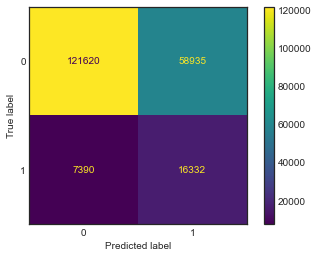

In [10]:
# Labels
class_label = ['service', 'default']

# Print model evaluation
print('Baseline Model Evaluation:')
print(classification_report(log_y, y_pred, target_names= class_label))

conf_matrix = confusion_matrix(log_y, y_pred)
plt.style.use('seaborn-white')
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot();

**Service**
- The model had a 94% precision when predicting whether the person paid back the loan and a recall of 67%. This indicates that the model favours precision over recall.

- From the confusion matrix, we see that the model is best at predicting serviced loans than defaulted ones.

**Default**
- The model had a difficult time predicting defaults, the precision on the defaults is 22%, whereas the recall is 69%, indicating that the model, when it comes to defaults, it chooses recall over precision.

#### **Summary**
- The model shows signs of class imbalance despite using the `class_weight` parameter. 

- It also has an accuracy of 68% which is relatively low, meaning that the model is not working as well as we want it to.

- Overall, the model favours recall over precision, meaning that the model is trying really hard not to miss any defaulters, even if that means incorrectly flagging some people as defaulters when they actually wouldn’t have defaulted.

- This is good because it means that we are able to flag almost every defaulter, but it is also bad as people who do not default may be flagged as defaulters, which may hurt their chances of being grannted loans.

### **Model 2: Applying SMOTE**
For the second model, we are applying the class imbalance tool, `Synthetic Minority Over-sampling Technique (SMOTE)`, it works the same as the class_weight, but it goes an extra mile and generates synthetic samples for the minority class.

This is important because having an imbalanced class makes the model unreliable.

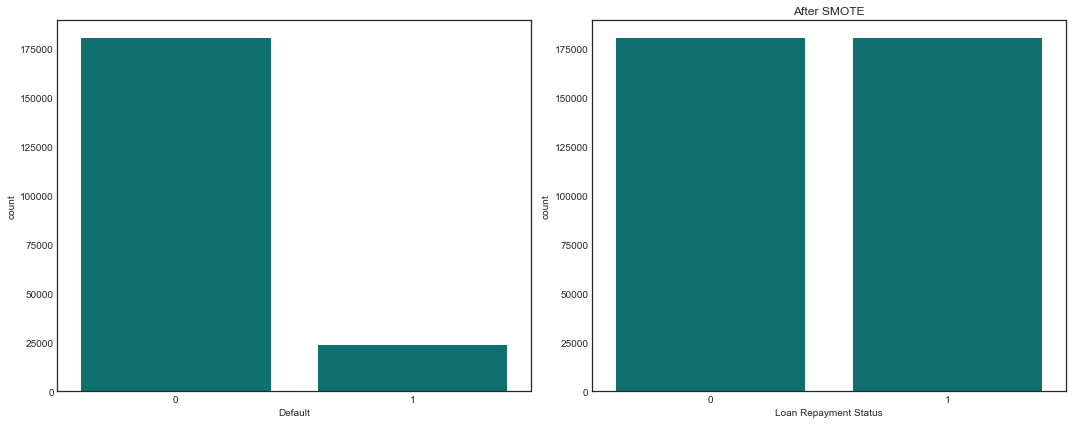

In [11]:
# Apply SMOTE on the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(log_X, log_y)

# Create plot figure
fig, (ax1, ax2) = plt.subplots(figsize = (15, 6), ncols= 2)

# Plot ax1, before SMOTE
sns.countplot(x= log_y, ax= ax1, color= 'teal')
plt.title('Before SMOTE')
plt.xlabel('Loan Repayment Status')

# Plot ax2, after SMOTE
sns.countplot(x= y_train_resampled, ax= ax2, color= 'teal')
plt.title('After SMOTE')
plt.xlabel('Loan Repayment Status')

plt.tight_layout()
plt.show()

In [12]:
# Train and fit the SMOTE model
log_reg = LogisticRegression(solver= 'saga', max_iter= 500).fit(X_train_resampled, y_train_resampled)

# Predict y
y_pred = log_reg.predict(X_train_resampled)

#### *Evaluation*
Here we are focusing on recall vs precision, this is because we have applied SMOTE to deal with class imbalance, and by evaluating the model by those two metrics, we'll get to know if the SMOTE has worked.

Baseline Model Evaluation:
              precision    recall  f1-score   support

     service       0.70      0.68      0.69    180555
     default       0.69      0.70      0.70    180555

    accuracy                           0.69    361110
   macro avg       0.69      0.69      0.69    361110
weighted avg       0.69      0.69      0.69    361110



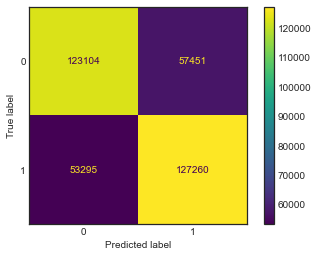

In [13]:
# Print model evaluation
print('Baseline Model Evaluation:')
print(classification_report(y_train_resampled, y_pred, target_names= class_label))

conf_matrix = confusion_matrix(y_train_resampled, y_pred)
plt.style.use('seaborn-white')
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot();

**Service**
- Compared to the baseline model, the precision on the serviced loans has one down to 70%, from 94%. Recall has gone up, only by 1% to stand at 68%.

**Default**
- This model has done a better job predicting defaulters than the baseline model. The precision score has gone up to 69% as the recall score has gone up by 1% to stand at 70%.

#### **Summary**
- This model set to deal with the class imbalance in the target variable, in the baseline model, the model best predicted the non-defaulters, underpredicting the defaulters. However, in this mode, both the defaulters and the non defaulters have been predicted equally.

- The confusion matrix above shows that the model equally predicts the 2 classes, the true positives and the negatives are almost equal, whereas the false positives and negatives are also almost equal.

- In this model, the precision, accuracy and recall scores are all equal, standing at 69%. This means that the model's performance is evenly balanced between being accurate (precision) and complete (recall), and the F1-score reflects that.

- This means that:
   - we are getting consistent predictions for that class.

   - The model isn't favoring precision over recall (or vice versa).

The overall performance is good, compared to the other model performance, however, 69% is still quite low, meaning the model can still be improved.

### **Model 3: Hyperparameter Tuning**
As we have already dealt with the class imbalance issue, here we are tuning the parameters to push our model to get better accuracy results as well as just work optimally over all.

We are setting the `penalty=` parameter to `elasticnet`, to regularize the model as well as choose the best features.

In [14]:
# Prepara data for modeling
elasticnet_X = X_train_resampled.copy()
elasticnet_y = y_train_resampled.copy()

# Train and fit the SMOTE model
log_reg = LogisticRegression(penalty= 'elasticnet', l1_ratio= 1, solver= 'saga', max_iter= 500).fit(elasticnet_X, elasticnet_y)

# Predict y
y_pred = log_reg.predict(elasticnet_X)

#### *Evaluation*

Baseline Model Evaluation:
              precision    recall  f1-score   support

     service       0.70      0.68      0.69    180555
     default       0.69      0.70      0.70    180555

    accuracy                           0.69    361110
   macro avg       0.69      0.69      0.69    361110
weighted avg       0.69      0.69      0.69    361110



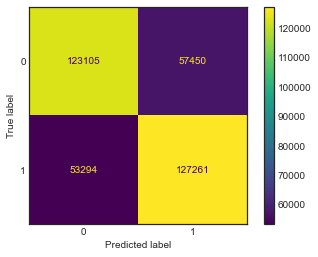

In [15]:
# Print model evaluation
print('Baseline Model Evaluation:')
print(classification_report(elasticnet_y, y_pred, target_names= class_label))

conf_matrix = confusion_matrix(elasticnet_y, y_pred)
plt.style.use('seaborn-white')
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot();

#### **Summary**
This model performs the same as the previous model, indicating that there's need for `GridSearchCV()`.

### **Model 4: GridSearchCV**
Despite solving the class imbalance issues, our model remains unreliable, with our accuracy score standing at 69%. In this section, we are using `GridSearchCV()` to tune our hyperparameters and find parameters that yield maximum scores for our model.

In [16]:
# Prepara data for modeling
rand_X = X_train_resampled.copy()
rand_y = y_train_resampled.copy()

# Define model
log_reg = LogisticRegression(l1_ratio= 1, solver= 'saga')

# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [100, 500, 1000],
    'penalty' : ['elasticnet', 'l2']
}

# Set up RandomizedSearchCV
rand_search = RandomizedSearchCV(estimator=log_reg, param_distributions=param_grid, 
                           cv=5, scoring='f1_macro', n_jobs=-1, verbose= 1)

# Fit to training data
rand_search.fit(rand_X, rand_y)

# Print best parameters
print("Best params:", rand_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.8min finished


Best params: {'penalty': 'elasticnet', 'max_iter': 100, 'C': 1}


#### *Evaluation*

In [17]:
# Predict the train data.
y_pred = rand_search.predict(rand_X)

# Print model evaluation
print('Baseline Model Evaluation:')
print(classification_report(rand_y, y_pred, target_names= class_label))

Baseline Model Evaluation:
              precision    recall  f1-score   support

     service       0.70      0.68      0.69    180555
     default       0.69      0.70      0.70    180555

    accuracy                           0.69    361110
   macro avg       0.69      0.69      0.69    361110
weighted avg       0.69      0.69      0.69    361110



#### **Summary**
- RandomizedSearchCV was applied to tune hyperparameters, but no significant gains in F1 or recall were observed.

- Despite tuning, Logistic Regression underperformed on recall and overall F1. Given the business goal is to catch as many defaulters as possible, having a higher accuracy score is important, we proceed to try more flexible algorithms such as Decision Trees or Random Forest to help achieve this goal.

### **ROC**

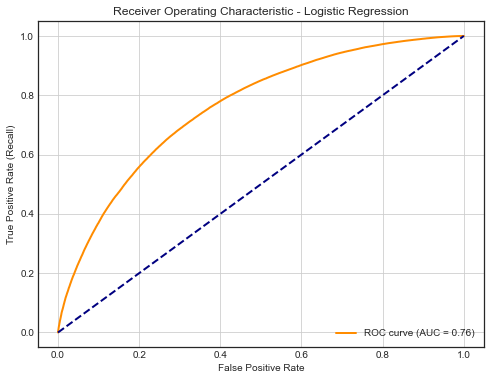

In [ ]:
# Get predicted probabilities for the positive class
y_scores = rand_search.predict_proba(rand_X)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(rand_y, y_scores)
roc_auc = roc_auc_score(rand_y, y_scores)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### **ROC Summary**
The model has an ROC of 0.76.
- 0.76 means the logistic regression model does a decent job distinguishing between defaulters and non-defaulters, especially given the class imbalance.

- There’s a 76% chance that the model will assign a higher probability score to a randomly chosen defaulter than to a randomly chosen non-defaulter.